In [127]:
import sys
sys.path.append('..')


file = '../data/fault_sim/results/cross_comparison_github.csv'
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import pandas as pd
plt.rcParams['figure.dpi'] = 300
df = pd.read_csv(file)
thresh = 0.5

In [128]:


f_dict = {0: (-1, -1, -1), 1: (-1, -1, 1), 2: (-1, 1, -1), 3: (1, -1, -1), 4: (-1, 1, 1), 5: (1, 1, -1),
          6: (1, -1, 1), 7: (1, 1, 1)} # 1 : is a path, -1 : is a barrier.
f_dict_binary = {0: (0, 0, 0), 1: (0, 0, 1), 2: (0, 1, 0), 3: (1, 0, 0), 4: (0, 1, 1), 5: (1, 1, 0),
          6: (1, 0, 1), 7: (1, 1, 1)} # 1 : is a path, 0 : is not a path.
flt_classification = {1:{3,5,6,7}, 2:{2,4,5,7}, 3:{1,4,6,7}}
numerical_columns = [f'{j}' for j in range(8)]
def transform_df(df:pd.DataFrame, thresh = 0.3):
    new_df = df.copy()
    flt_id_series = df.index//10
    source_id_series = df.index%10
    binary_df = df > thresh
    new_df['thresh_nb'] = np.sum([binary_df[f'{i}'] == True for i in range(8)], axis = 0)
    new_df['flt_id'] = flt_id_series
    new_df['source_id'] = source_id_series
    
    for i, row in df.iterrows():
        
        flt_id = flt_id_series[i]
        new_df.loc[i,'thresh_acceptance'] = (row[str(flt_id)]>= thresh).astype(int)
        #first value method
        local_max = np.max(row[numerical_columns])
        new_df.loc[i,'first_value_acceptance'] =  (row[str(flt_id)] >= local_max - 0.05).astype(int)
        thresholded_bool = row[numerical_columns] >local_max - 0.05
        new_df.loc[i,'first_value_nb'] = np.sum(thresholded_bool)
        
        # thresholded_scenarios = row[numerical_columns][thresholded_bool]
        thresholded_scenarios = row[numerical_columns]
        fault_topology_array = list()
        for j in thresholded_scenarios.index:
            fault_topology = f_dict[int(j)]
            fault_topology_array.append(fault_topology)
        fault_topology_array = np.array(fault_topology_array)
        predicted_topology = np.average(fault_topology_array == 1, axis = 0, weights = thresholded_scenarios)
        new_df.loc[i,'f_1_true'], new_df.loc[i,'f_2_true'], new_df.loc[i,'f_3_true'] = tuple(f_dict_binary[flt_id])
        new_df.loc[i,'f_1_pred'], new_df.loc[i,'f_2_pred'], new_df.loc[i,'f_3_pred'] = predicted_topology 
        new_df.loc[i,'f_1_pred_bool'], new_df.loc[i,'f_2_pred_bool'], new_df.loc[i,'f_3_pred_bool'] = round(new_df.loc[i,'f_1_pred'],0), round(new_df.loc[i,'f_2_pred']), round(new_df.loc[i,'f_3_pred'])
        # #combined method
        # new_df.loc[i,'combined_acceptance'] = ((row[str(flt_id)] >local_max - 0.05) & (row[str(flt_id)]>= thresh)).astype(int)
        # new_df.loc[i,'combined_nb'] = np.sum(((row[numerical_columns] >local_max - 0.05) & (row[numerical_columns]>= thresh)))
        
        
        # new_df.loc[i,'f_1'], new_df.loc[i,'f_2'], new_df.loc[i,'f_3'] = tuple(f_dict[flt_id])
        # for key,values in flt_classification.items():
        #     active_flt_ids = values
        #     inactive_flt_ids = set(range(8)).difference(active_flt_ids)
        #     active_flt_avg = np.mean([row[f'{i}'] for i in active_flt_ids])
        #     inactive_flt_avg = np.mean([row[f'{i}'] for i in inactive_flt_ids])
        #     new_df.loc[i,f'active_flt_{key}_avg'] = active_flt_avg 
        #     new_df.loc[i,f'inactive_flt_{key}_avg'] = inactive_flt_avg
        #     new_df.loc[i, f'difference_flt_{key}'] = active_flt_avg - inactive_flt_avg

                        
    return new_df

In [129]:
df = transform_df(df, thresh = thresh)

In [130]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_true=df['f_2_true'], y_pred=df['f_2_pred_bool'])

(array([0.74074074, 1.        ]),
 array([1.  , 0.65]),
 array([0.85106383, 0.78787879]),
 array([40, 40]))

Text(0.5, 0, 'Scenario')

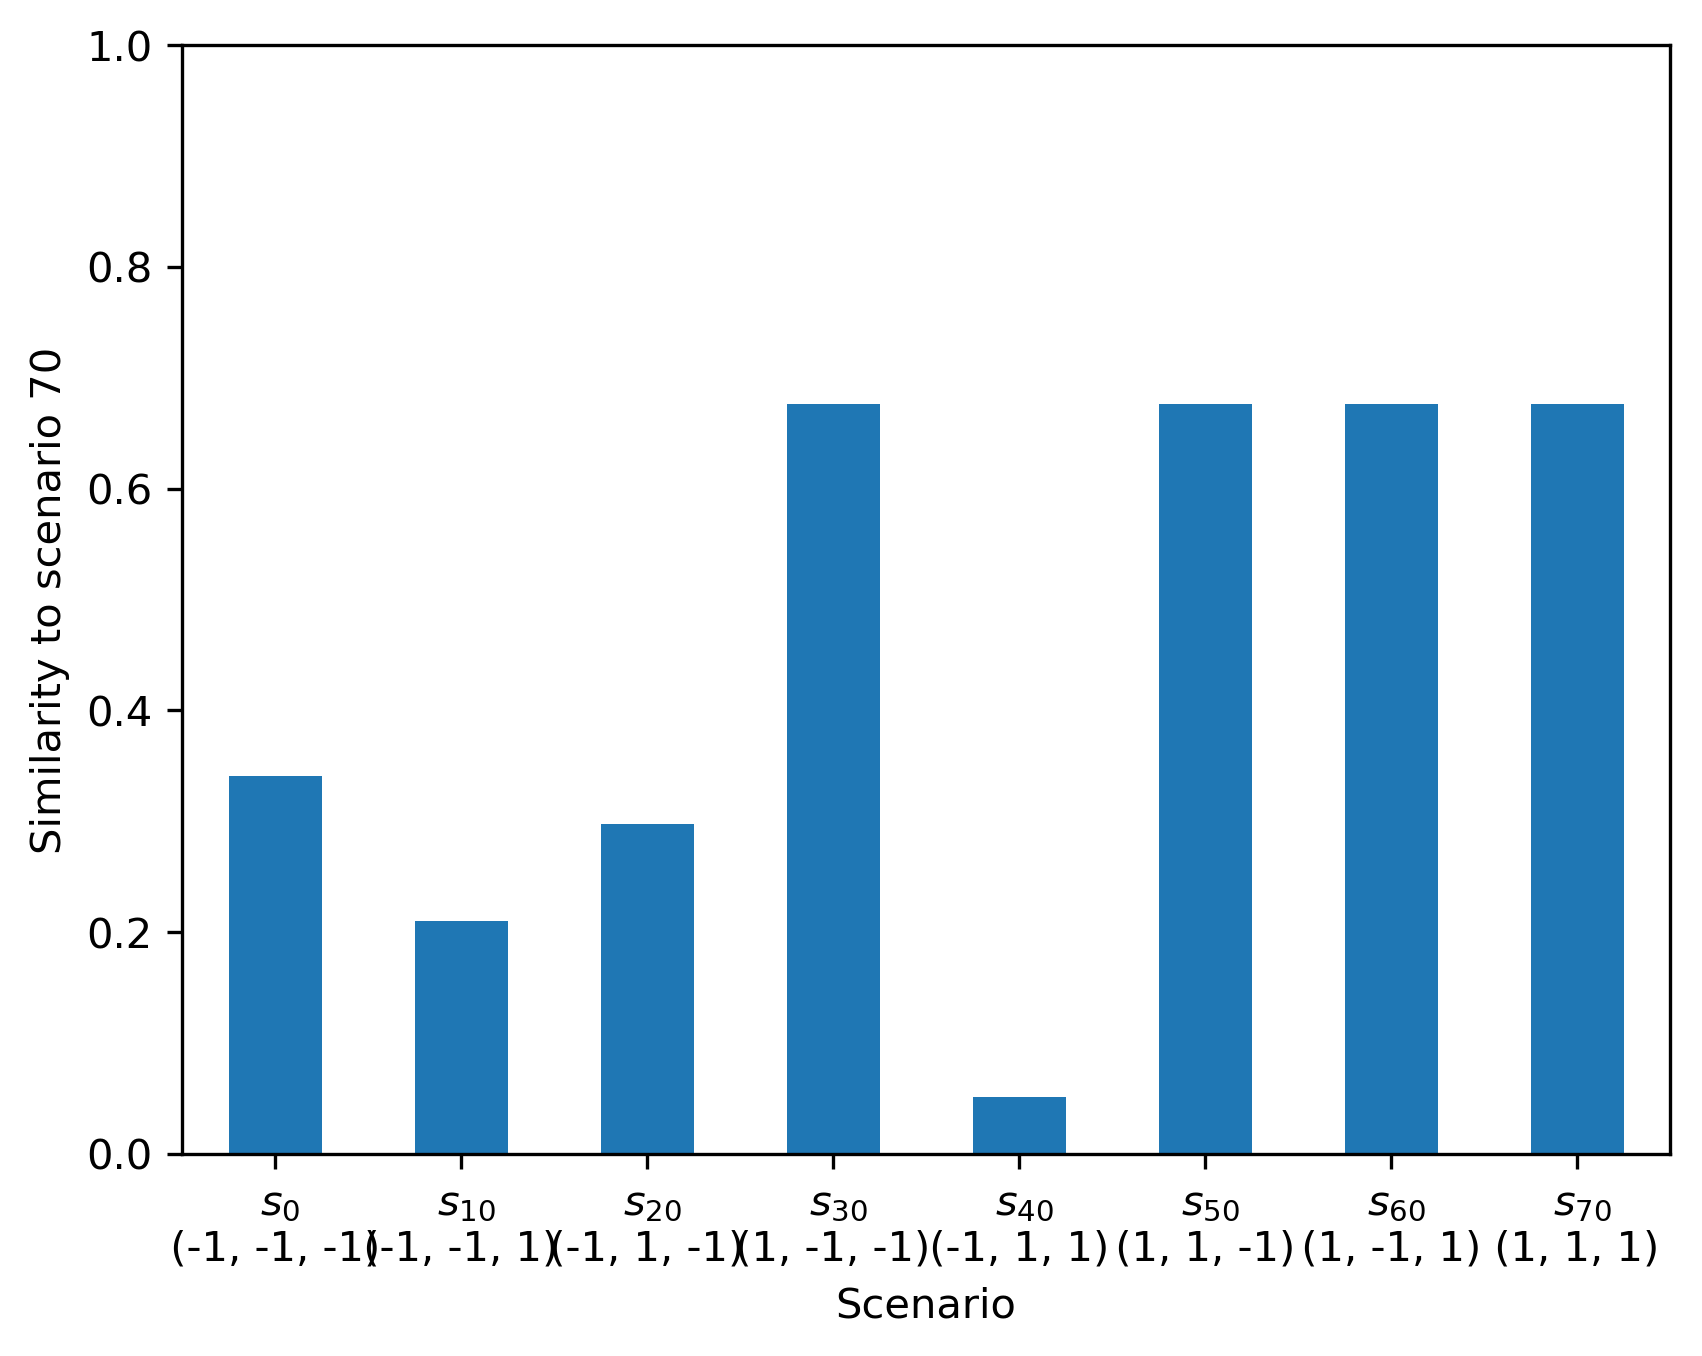

In [131]:
fig,ax = plt.subplots()
id = 70
source_id = int(str(id)[1])
df.loc[id
       ][numerical_columns].plot.bar(ax = ax)
ax.set_ylim(0,1)
xticklabels = [0]*8
for k in range(0,8):
       scenario_id = source_id + k*10
       xticklabels[k] = f" $s_{{{scenario_id}}}$ \n {f_dict[k]} "
ax.set_xticklabels(xticklabels, rotation=0)
ax.set_ylabel(r'Similarity to scenario 70')
ax.set_xlabel('Scenario')

In [132]:
df2 = df.groupby('flt_id').mean()

In [133]:
df2

,Unnamed: 0,0,1,2,3,4,5,6,7,thresh_nb,...,first_value_nb,f_1_true,f_2_true,f_3_true,f_1_pred,f_2_pred,f_3_pred,f_1_pred_bool,f_2_pred_bool,f_3_pred_bool
flt_id,,,,,,,,,,,,,,,,,,,,,
0,4.5,0.569334,0.450412,0.080218,0.220149,0.054407,0.212658,0.220149,0.212658,1.6,...,1.7,0.0,0.0,0.0,0.390139,0.254682,0.468640,0.3,0.0,0.1
1,14.5,0.288507,0.268031,0.069228,0.136692,0.045666,0.131876,0.136692,0.131876,0.0,...,1.9,0.0,0.0,1.0,0.364853,0.274868,0.494053,0.2,0.0,0.5
2,24.5,0.080271,0.097742,0.724984,0.047665,0.745988,0.150954,0.047665,0.150954,2.0,...,2.1,0.0,1.0,0.0,0.171863,0.855422,0.520293,0.0,1.0,0.9
3,34.5,0.311326,0.216054,0.075303,0.808749,0.051597,0.659074,0.808749,0.659074,3.6,...,3.2,1.0,0.0,0.0,0.815554,0.385901,0.484697,1.0,0.0,0.1
4,44.5,0.081303,0.098611,0.740225,0.049402,0.810820,0.146324,0.049402,0.146324,2.1,...,2.1,0.0,1.0,1.0,0.158723,0.862924,0.533637,0.0,1.0,0.9
5,54.5,0.269030,0.194414,0.191719,0.624816,0.166814,0.749566,0.624816,0.749566,3.6,...,3.4,1.0,1.0,0.0,0.762034,0.526449,0.486947,0.9,0.3,0.0
6,64.5,0.332062,0.220272,0.075954,0.693241,0.051348,0.571875,0.693241,0.571875,3.4,...,3.4,1.0,0.0,1.0,0.786464,0.381154,0.480187,1.0,0.0,0.1
7,74.5,0.288538,0.199904,0.194392,0.567679,0.169788,0.698054,0.567679,0.698054,3.6,...,3.4,1.0,1.0,1.0,0.744362,0.523264,0.484057,0.9,0.3,0.1


In [134]:
df

,Unnamed: 0,0,1,2,3,4,5,6,7,thresh_nb,...,first_value_nb,f_1_true,f_2_true,f_3_true,f_1_pred,f_2_pred,f_3_pred,f_1_pred_bool,f_2_pred_bool,f_3_pred_bool
0,0,0.346762,0.269569,0.309020,0.524108,0.050905,0.524108,0.524108,0.524108,4,...,4.0,0.0,0.0,0.0,0.682280,0.458277,0.445437,1.0,0.0,0.0
1,1,0.409941,0.297010,0.053825,0.454172,0.053825,0.454172,0.454172,0.454172,0,...,5.0,0.0,0.0,0.0,0.690417,0.386120,0.478541,1.0,0.0,0.0
2,2,0.686199,0.494738,0.055859,0.123579,0.055859,0.123579,0.123579,0.123579,1,...,1.0,0.0,0.0,0.0,0.276622,0.200829,0.446429,0.0,0.0,0.0
3,3,0.708206,0.541494,0.059203,0.129578,0.059203,0.129578,0.129578,0.129578,2,...,1.0,0.0,0.0,0.0,0.274759,0.200147,0.455813,0.0,0.0,0.0
4,4,0.292145,0.502924,0.055548,0.130460,0.055548,0.055548,0.130460,0.055548,1,...,1.0,0.0,0.0,0.0,0.291051,0.173834,0.582453,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,75,0.339782,0.216966,0.051790,0.681446,0.051790,0.630357,0.681446,0.630357,4,...,2.0,1.0,1.0,1.0,0.798922,0.415445,0.481300,1.0,0.0,0.0
76,76,0.314786,0.188584,0.050807,0.726332,0.050807,0.726332,0.726332,0.726332,4,...,4.0,1.0,1.0,1.0,0.827655,0.442775,0.482024,1.0,0.0,0.0
77,77,0.323468,0.209017,0.050887,0.736967,0.050887,0.736967,0.736967,0.736967,4,...,4.0,1.0,1.0,1.0,0.822938,0.439881,0.484025,1.0,0.0,0.0
78,78,0.322411,0.207153,0.051301,0.737162,0.051301,0.737162,0.737162,0.737162,4,...,4.0,1.0,1.0,1.0,0.823457,0.440382,0.483906,1.0,0.0,0.0


In [135]:
np.sum(df['f_1_pred_bool'] - df['f_1_true'] == 0) 

73

In [136]:
df2.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', 'thresh_nb',
       'source_id', 'thresh_acceptance', 'first_value_acceptance',
       'first_value_nb', 'f_1_true', 'f_2_true', 'f_3_true', 'f_1_pred',
       'f_2_pred', 'f_3_pred', 'f_1_pred_bool', 'f_2_pred_bool',
       'f_3_pred_bool'],
      dtype='object')

In [137]:
def compute_recall_precision(thresh_value = 0.4, method = 'thresh', file_csv = 'df/cross.csv'):
    df_thresh = pd.read_csv(file_csv)
    df_thresh = transform_df(df_thresh, thresh = thresh_value)
    acceptance = f'{method}_acceptance'
    nb = f'{method}_nb'
    recall_dict, precision_dict = {}, {}
    for id in range(1,4):
        (precision_1, precision_2), (recall_1, recall_2), _,_ = precision_recall_fscore_support(y_true=df_thresh[f'f_{id}_true'], y_pred=df_thresh[f'f_{id}_pred_bool'])
        # (precision), (recall), _,_ = precision_recall_fscore_support(y_true=df_thresh[f'f_{id}_true'], y_pred=df_thresh[f'f_{id}_pred_bool'],average= 'micro')

        # precision, recall = None, np.sum(df_thresh[f'f_{id}_true'] - df_thresh[f'f_{id}_pred_bool'] == 0)/80
        precision_dict[id], recall_dict[id] = (precision_1, precision_2), (recall_1, recall_2)
        
        
    
    recall, precision  = recall_dict, precision_dict
    nb_average = df_thresh[nb].mean()
    FP = ((df_thresh[nb] != 0)& (df_thresh[acceptance] == 0)  ).sum()
    TP = ((df_thresh[nb] != 0)& (df_thresh[acceptance] == 1)  ).sum()
    FN = ((df_thresh[nb] == 0)& (df_thresh[acceptance] == 0)  ).sum()
    success_rate  =  TP/(TP+FP+FN)
    ratio = success_rate/nb_average
    return [recall, precision, success_rate, nb_average, ratio]


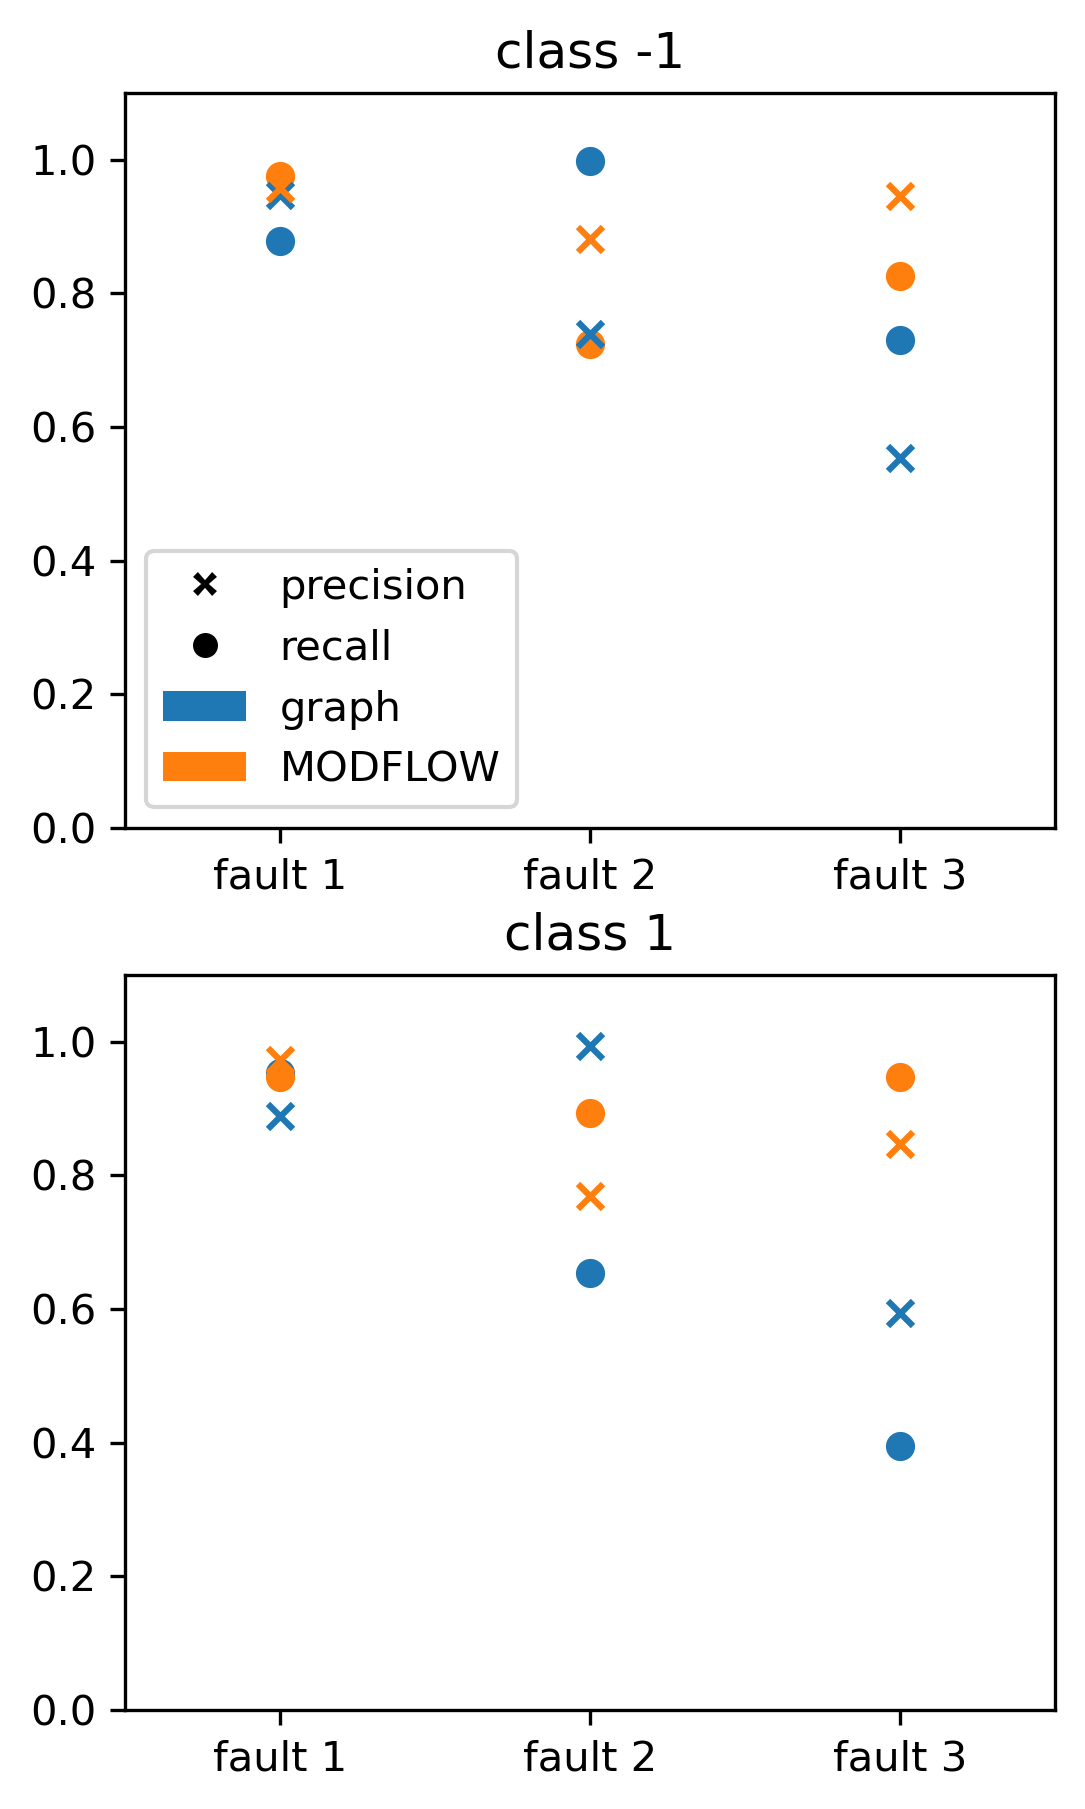

In [138]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
def plot_recall_precision(file_csv = file, color = 'C0', label = 'GRAPH'):
    plt.rcParams['figure.dpi'] = 300
    recall_ig, precision_ig,_,_,_  = compute_recall_precision(thresh_value= 0, file_csv= file_csv)
    recall_mf, precision_mf,_,_,_  = compute_recall_precision(thresh_value= 0, file_csv= '../data/fault_sim/results/cross_comparison_mf.csv')
    fig, axs = plt.subplots(2,1, sharey=False, figsize=(4,7))
    for ax_id in range(2):
        for key, value in recall_ig.items():
            if key == 1:
                axs[ax_id].scatter(key,value[ax_id]+np.random.normal(0,0.005), marker = 'o', c= color, label = label)
            else :
                axs[ax_id].scatter(key,value[ax_id]+np.random.normal(0,0.005), marker = 'o', c= color)
        for key, value in recall_mf.items():
            if key == 1:
                axs[ax_id].scatter(key,value[ax_id]+np.random.normal(0,0.005), marker = 'o', c= 'C1', label = label)
            else :
                axs[ax_id].scatter(key,value[ax_id]+np.random.normal(0,0.005), marker = 'o', c= 'C1')
        for key, value in precision_ig.items():
            if key == 1:
                axs[ax_id].scatter(key,value[ax_id]+np.random.normal(0,0.005), marker = 'x', c= color, label = label)
            else :
                axs[ax_id].scatter(key,value[ax_id]+np.random.normal(0,0.005), marker = 'x', c= color)
        for key, value in precision_mf.items():
            if key == 1:
                axs[ax_id].scatter(key,value[ax_id]+np.random.normal(0,0.005), marker = 'x', c= 'C1', label = label)
            else :
                axs[ax_id].scatter(key,value[ax_id]+np.random.normal(0,0.005), marker = 'x', c= 'C1')
        axs[ax_id].set_ylim(0,1.1)
        axs[ax_id].set_xticks([1,2,3], labels = ["fault 1","fault 2","fault 3"])
        
        # axs[ax_id].set_xlabel('Fault id')
        axs[ax_id].set_xlim(0.5,3.5)
    
    axs[0].set_title('class -1')
    axs[1].set_title('class 1')
    legend_elements = [Line2D([0], [0], marker='X', color='w', label='precision',
                          markerfacecolor='black',markersize=7),
                   Line2D([0], [0], marker='o', color='w', label='recall',
                          markerfacecolor='black',markersize=7),
                   Patch(facecolor='C0',
                         label='graph'),
                   Patch(facecolor='C1',
                         label='MODFLOW')
                   ]
    axs[0].legend(handles=legend_elements)
plot_recall_precision()
   


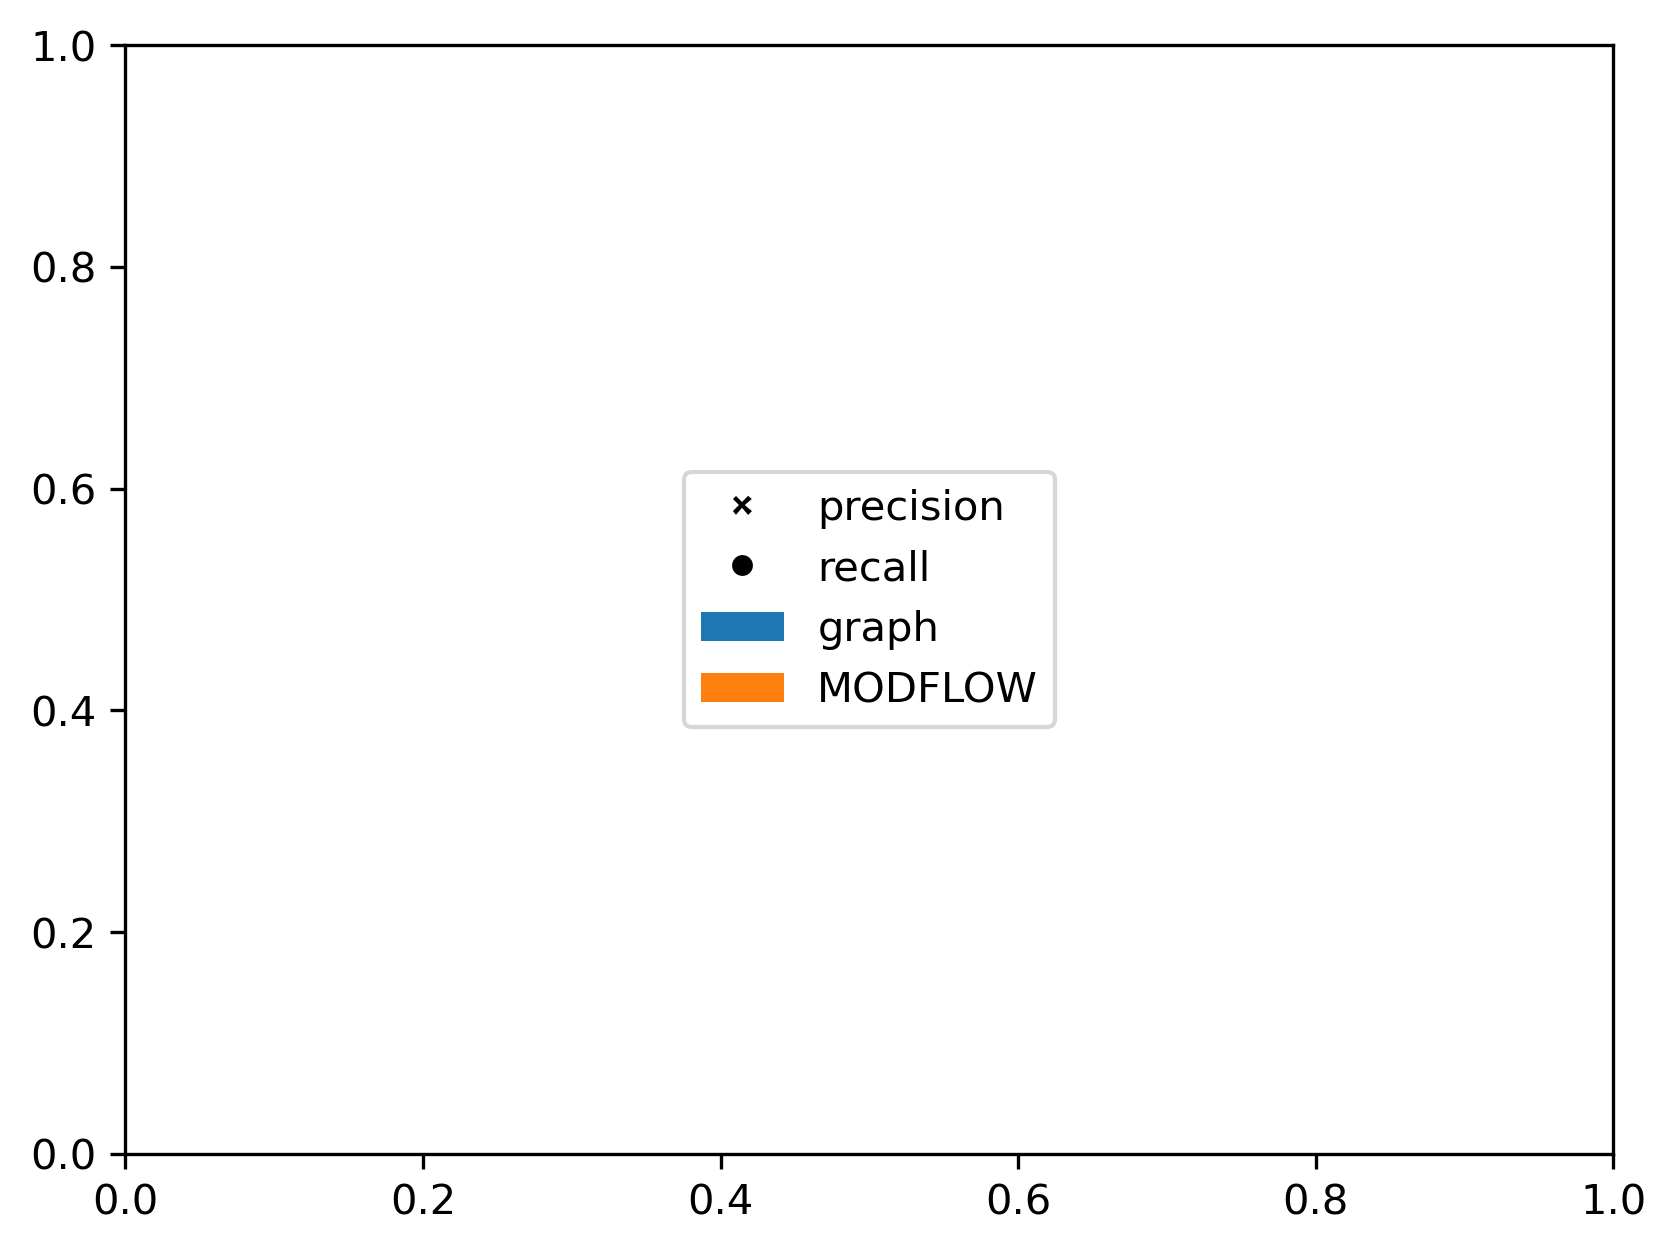

In [139]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
plt.rcParams['figure.dpi'] = 300
legend_elements = [Line2D([0], [0], marker='X', color='w', label='precision',
                          markerfacecolor='black'),
                   Line2D([0], [0], marker='o', color='w', label='recall',
                          markerfacecolor='black'),
                   Patch(facecolor='C0',
                         label='graph'),
                   Patch(facecolor='C1',
                         label='MODFLOW')
                   ]
fig,ax = plt.subplots()
ax.legend(handles=legend_elements, loc='center')


In [140]:
####
def plot_results(file_csv = file):  
    thresh_set = np.linspace(0,0.99,20)
    thresh_success, thresh_n, thresh_ratio = [],[],[]
    for thresh_value in thresh_set:
        recall_dict, precision_dict, success_rate, n ,ratio = compute_recall_precision(thresh_value , method = 'thresh', file_csv= file_csv)
        thresh_success.append(success_rate), thresh_n.append(n), thresh_ratio.append(ratio)
    
    first_value_recall, first_value_precision, first_value_success, first_value_n, first_value_ratio = compute_recall_precision(method = 'first_value', file_csv= file_csv)

    fig,ax = plt.subplots()
    X = np.linspace(0,8,9)
    sc = ax.scatter(thresh_n, thresh_success, c = thresh_set, marker = 'o', label = r'$g_{\lambda}$', cmap = 'cividis')
    fig.colorbar(sc,ax = ax, label = r'Threshold $\lambda$')
    ax.scatter(first_value_n, first_value_success, marker = 'x', c = 'red', label = r'$u$' )
    

    
    ax.scatter(X, (1/8)*X, marker= '+', label = r'$h_{k}$', c = 'black')
    ax.legend()
    # ax.set_title('success')
    ax.set_ylabel(r'$\bar{Y}(f)$')
    ax.set_xlabel(r'$\bar{w}(f)$')
    ax.legend()
    
    fig.tight_layout()



/tmp/ipykernel_2797566/2285369708.py:22: RuntimeWarning: invalid value encountered in double_scalars
  ratio = success_rate/nb_average
/tmp/ipykernel_2797566/2285369708.py:22: RuntimeWarning: invalid value encountered in double_scalars
  ratio = success_rate/nb_average
/tmp/ipykernel_2797566/2285369708.py:22: RuntimeWarning: invalid value encountered in double_scalars
  ratio = success_rate/nb_average


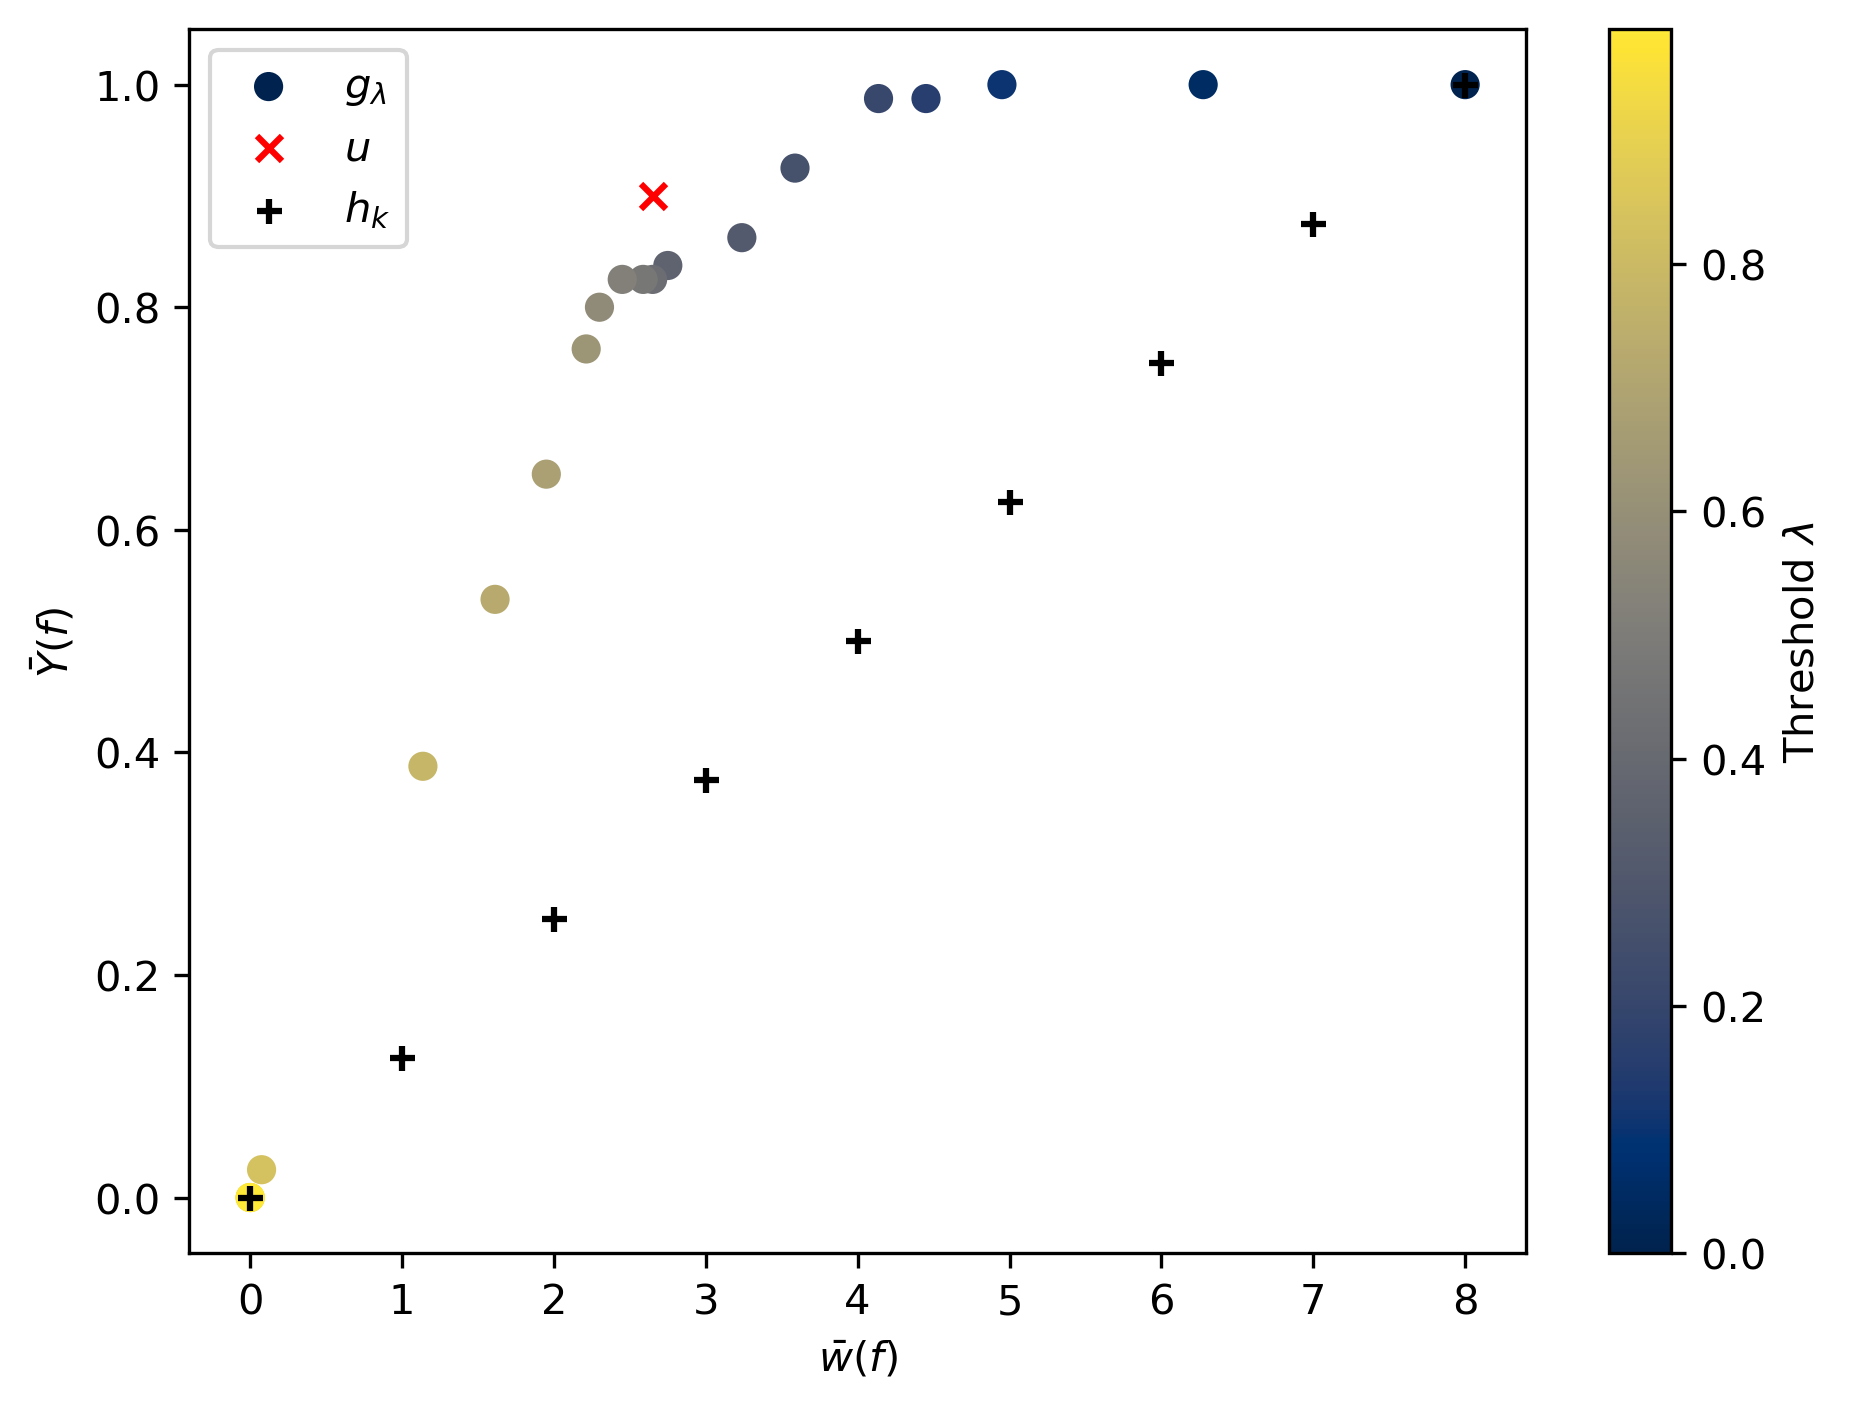

In [141]:
plot_results()

In [142]:
def plot_results_2(file_csv = file, fig = None, ax = None, linestyle = '-'):  
    thresh_set = np.linspace(0,0.999,15)
    thresh_success, thresh_n, thresh_ratio = [],[],[]
    for thresh_value in thresh_set:
        recall_dict, precision_dict, success_rate, n ,ratio = compute_recall_precision(thresh_value , method = 'thresh', file_csv= file_csv)
        thresh_success.append(success_rate), thresh_n.append(n), thresh_ratio.append(ratio)
    
    first_value_recall, first_value_precision, first_value_success, first_value_n, first_value_ratio = compute_recall_precision(method = 'first_value', file_csv= file_csv)
    if fig is None:
        fig,ax = plt.subplots()
    X_0 = 0
    X_1 = len(thresh_success)*[1]
    X_2 = 2
    linestyle = linestyle
    sc = ax.plot(thresh_set, thresh_ratio, label = r'$g_{\lambda}$', linestyle = linestyle, c = 'C0')

    ax.hlines( first_value_ratio, linestyle = linestyle, label = r'$u$', xmin = 0, xmax = 1, colors = ['C1'])
    

    
    ax.hlines( 1/8, linestyle = linestyle, label = r'$g_k$', xmin = 0, xmax = 1, colors = ['C2'])
    ax.legend()
    ax.set_title('success')
    ax.set_ylabel(r'$\bar{Y}(f)/\bar{w}(f)$')
    
    ax.legend()
    ax.set_ylim(0,1)
    fig.tight_layout()
    return fig, ax


/tmp/ipykernel_2797566/2285369708.py:22: RuntimeWarning: invalid value encountered in double_scalars
  ratio = success_rate/nb_average
/tmp/ipykernel_2797566/2285369708.py:22: RuntimeWarning: invalid value encountered in double_scalars
  ratio = success_rate/nb_average
/tmp/ipykernel_2797566/2285369708.py:22: RuntimeWarning: invalid value encountered in double_scalars
  ratio = success_rate/nb_average


(<Figure size 1920x1440 with 1 Axes>,
 <Axes: title={'center': 'success'}, ylabel='$\\bar{Y}(f)/\\bar{w}(f)$'>)

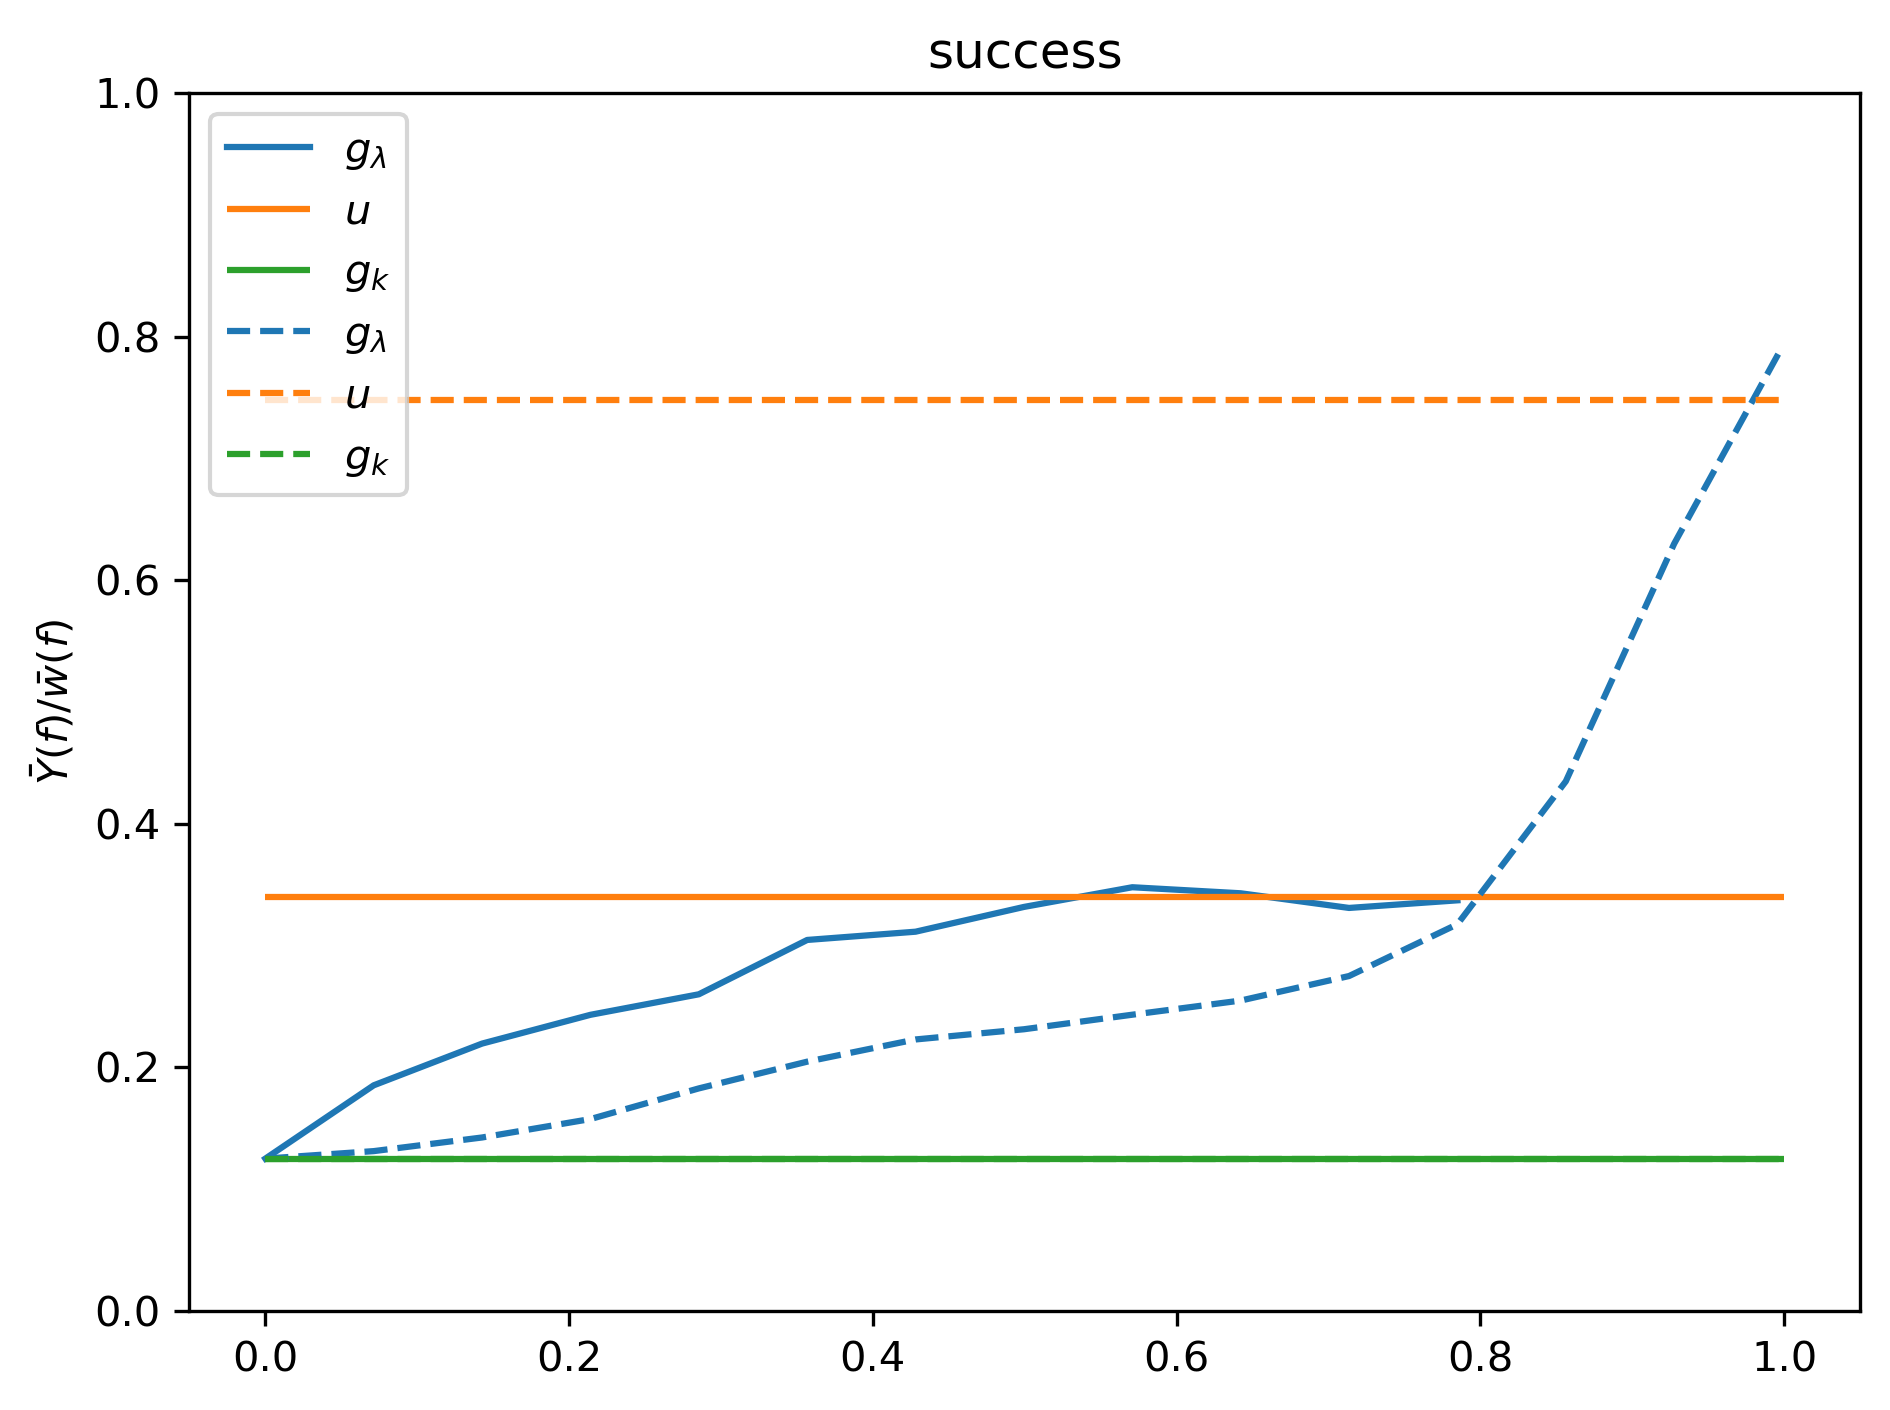

In [143]:
fig,ax = plot_results_2()
plot_results_2(file_csv = '../data/fault_sim/results/cross_comparison_mf.csv', fig = fig, ax = ax, linestyle= '--')
